# Unsupervised Learning

### Bastien Bigué, Thibaut Sarion


In [1]:
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as npy
import time
from sklearn.cluster import KMeans


### Fetching Digits from datasets

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits=load_digits()
data,target=digits['data'],digits['target']


### Plotting digit

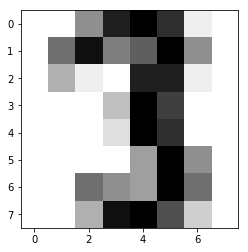

In [7]:
from random import randint

# Plot an image according to a given number
def plotImage(number):
    numberToPlot=data[target==number]
#     print(len(numberToPlot))
    if len(numberToPlot):
        index=randint(0,len(numberToPlot)-1)
        imageToPlot=npy.reshape(numberToPlot[index],(8,8))
        plt.imshow(imageToPlot, cmap=plt.cm.gray_r, interpolation='none')
        plt.show()
    else : 
        print("Not a good Number to plot")
plotImage(3)

### K-means classification


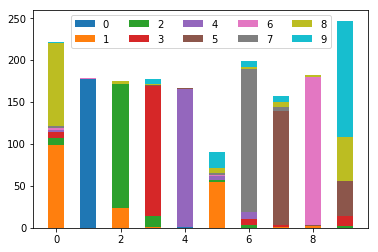

In [8]:
n_clusters=10
clustering=KMeans(n_clusters=n_clusters)
predictedTarget=clustering.fit_predict(data)

matrixToPlot=npy.zeros((10,n_clusters))
for clusterId in range(n_clusters):
    realTarget=target[predictedTarget==clusterId]
    unique, counts = npy.unique(realTarget, return_counts=True)
    occurencesDict=dict(zip(unique, counts))
    for cible,occurence in occurencesDict.items():
#         print(cible,occurence)
        matrixToPlot[cible][clusterId]=occurence

ind = npy.arange(n_clusters)    # the x locations for the groups

labels=[]
bottom=npy.zeros(n_clusters)
for index in range(10):
    p=plt.bar(ind,matrixToPlot[index],bottom=bottom,width=0.5)
    bottom=bottom+matrixToPlot[index]
    labels.append(p)
    plt.legend(p,str(index))
    
# p2=plt.bar(ind,matrixToPlot[1],bottom=matrixToPlot[0],width=0.2)

plt.legend(labels,[str(i) for i in range(10)],loc='upper center',ncol=5,fancybox=True)
plt.show()

Avec l'exemple ci-dessus, nous avons pris k=10, si on entraine notre classifieur avec les data digits, celle ci sont réparties dans 10 classes différentes. Il est ainsi intéressant de se rendre compte de la répartition de chaque digit dans les classes.<br>
A travers ce plot, on peut se rendre compte que le chiffre 0 est très souvent isolé dans une classe, tandis que les chiffres 1 et 8 sont souvent regroupés dans un même cluster

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### Méthodes de scoring : 

Il existe différentes méthodes de scoring. Chaque méthode quantifie différentes caractéristiques des méthodes de clustering : 

##### __silhouette_score()__ : calcule la moyenne des "__silhouette coefficients__" pour tous les points.
- silhouette coefficient : Pour un point donné, on va s'intéresser à la distance de celui-ci par rapport à son centroïde (__a__) et la distance entre le centroïde du cluster voisin le plus proche (__b__).  
- Le Silhouette Coefficient vaut alors : __$SC =  (b - a) / max(a,b) $__ 
<br> Interprétation : 
- Ainsi, si le point est très proche de son centroïde, et le cluster voisin est loin, $SC => 1$. C'est l'objectif à atteindre.
- A l'inverse $SC => -1 $ signifie que le point n'appartient pas au bon cluster
- $SC = 0 $ signifie que les clusters se chevauchent

#####  __homogeneity_score__ : Qualifie l'homogénéité des clusters, c'est à dire si chaque cluster regroupe des échantillons qui appartiennent à la même classe. 
- Si nous revenons sur le le diagramme en barre affiché en début de ce notebook, bien souvent, il existe un cluster qui regroupe __seulement__ des échantillons de digit dont la valeur est 0. On peut donc dire que ce cluster est homogène et son  __homogeneity_score<u>~</u>1__ 

#####  __completeness_score__ : A l'inverse du score d'homogénéité, cette fois-ci on cherche à qualifier le regroupement d'une classe au sein d'un même cluster. 
- On obtient alors un score proche de 1 si chaque classe (digit 0 par ex) est présent dans un seul cluster.

#####  __v_measure_score__ : Le V-measure score est une résultante des deux scores précédents :
- v = 2 * (homogeneity * completeness) / (homogeneity + completeness). 
- Plus le score est proche de 1, plus le classifieur pourra être qualifié d'homogène et Complémentaire. C'est à dire que chaque classe de base a été identifiée dans un cluster différent.

Afin de scorer l'algorithme K-means, nous utiliserons la méthode __silhouette_score()__. <br>
Les autres méthodes seront utilisées pour les algortihmes d'apprentissage suivants. 

In [11]:
from sklearn.metrics import silhouette_score

def scoreKmeans(k=10, init='k-means++',n_init=60,max_iter=500,data=data) : 
    summary={}
    clustering=KMeans(n_clusters=k, init=init,n_init=n_init,max_iter=max_iter)
    startTime=time.time()
    clustering.fit(data)
    predictedTarget=clustering.predict(data)
    score=silhouette_score(data,predictedTarget)
    summary['time']=time.time()-startTime
    summary['score']=score
    summary['k']=k
    summary['init']=init
    return summary

In [13]:
# Testing
scoreKmeans()

{'init': 'k-means++',
 'k': 10,
 'score': 0.18275333635318694,
 'time': 1.634446620941162}

## Variation du nombre de clusters & seeds

In [19]:
# clustering=KMeans(n_clusters=10, init='k-means++',n_init=10)
seeds=['random','k-means++']
summaryList=[]
for seed in seeds : 
    for k in range(2,15):
        summary=scoreKmeans(k=k,init=seed)
        summaryList+=[summary]
#     print(summary)

### plotting result

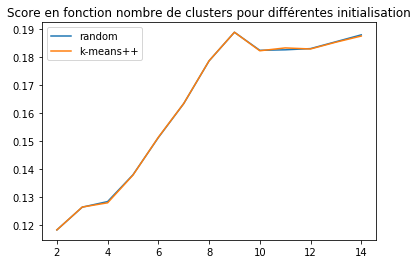

In [20]:
for seed in seeds : 
    score=npy.array([(x['k'],x['score']) for x in summaryList if x['init']==seed])
    plt.plot(score[:,0],score[:,1],label=seed)
plt.legend()
plt.title("Score en fonction nombre de clusters pour différentes initialisation")
plt.show()


D'après notre méthode de scoring, le meilleur nombre de cluster pour maximiser le score de silhouette est 9

### Analyse en composantes principales 
__L'analyse en composante principale__ est une technique visant à réduire le nombre de dimensions des données analysées dans un objectif de réduire la complexité d'un problème <br>
Elle se base sur une transformation des variables liées ( corrélées ) en nouvelles variables décorélées les unes des autres que l'on appelle composantes principales. A travers cette réduction de redondance et dimunition du nombre de variables, on diminue alors la complexité du problème et gagne donc en temps d'exécution

In [14]:
from sklearn.decomposition import PCA

def varPCA(n_components=8,k_constant=9) :
    pca = PCA(n_components=n_components)
    newData=pca.fit_transform(data)
    summary=scoreKmeans(k=k_constant,data=newData)
    return summary

In [22]:
summaryList=[]
for n_components in range(2,40):
    summary=varPCA(n_components=n_components)
    summary['PCA']=n_components
    summaryList+=[summary]

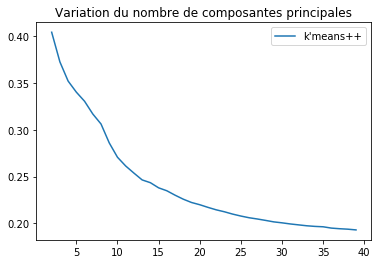

In [23]:
score=npy.array([(x['PCA'],x['score']) for x in summaryList])
plt.plot(score[:,0],score[:,1],label="k'means++")

plt.legend()
plt.title("Variation du nombre de composantes principales")
plt.show()


### BenchMarking K-means

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.36s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.29s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.06s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


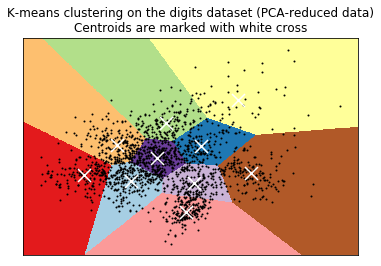

In [24]:
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans


npy.random.seed(42)
digits = load_digits()
data = scale(digits.data)
n_samples, n_features = data.shape
n_digits = len(npy.unique(digits.target))
labels = digits.target
sample_size = 300
print("n_digits: %d, \t n_samples %d, \t n_features %d" % (n_digits, n_samples, n_features))
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
def bench_k_means(estimator, name, data):
    t0 = time.time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f' % (name, (time.time() - t0), estimator.inertia_,
    metrics.homogeneity_score(labels, estimator.labels_),
    metrics.completeness_score(labels, estimator.labels_),
    metrics.v_measure_score(labels, estimator.labels_),
    metrics.adjusted_rand_score(labels, estimator.labels_),
    metrics.adjusted_mutual_info_score(labels, estimator.labels_),
    metrics.silhouette_score(data, estimator.labels_,metric='euclidean',sample_size=sample_size)))
    
bench_k_means(KMeans(init='k-means++',n_clusters=n_digits,n_init=10), name="k-means++", data=data)
bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),name="random", data=data)
# # in this case the seeding of the centers is deterministic, hence
# # we run the kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_,n_clusters=n_digits,n_init=1),name="PCA-based",data=data)
print(82 * '_')

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02
# point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,
0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,
1].max() + 1
xx, yy = npy.meshgrid(npy.arange(x_min, x_max, h), npy.arange(y_min,
y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(npy.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
extent=(xx.min(), xx.max(), yy.min(), yy.max()),
cmap=plt.cm.Paired,
aspect='auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
marker='x', s=169, linewidths=3,
color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()



Le code qui précède effectue un benchmark du classifieur K-means afin de comparer différentes initialisation du classifieur __('k-means++', 'random', 'PCA' )__ . Nous pouvons retenir différents points importants de ces résultats :
- Différentes méthodes de scoring ont été utilisées afin de mettre en évidence plusieurs caractéristiques
- Pour afficher une telle classification, on utilise une PCA sur deux composantes ( axe X,Y ) de manière à pouvoir représenter la répartition des clusters en 2D

- Le classifieur utilisant l'analyse en composantes principales est bien plus rapide en temps d'execution que les autres. Cependant il obtient un score moins bon. 

### Bilan sur K-Means
- K-means est un classifieur dont le but est de minimiser l'inertie ( Somme des carrés de la distance de chaque échantillon par rapport à leur centroîde associé )
- Il est important de noter que K-means est un classifieur non supervisé. En effet, il n'utilise pas les target des samples pour s'entrainer.
- Il n'est pas facile de scorer un tel classificateur car il existe de très nombreuses métriques pour cela. 

### Remarques
- L'une des difficultés dans K-means est de déterminer K, le nombre de cluster. En effet K-means vise à classifier des données non classées. On a en effet aucune connaissance préalable sur les jeux de données et également aucune idée du nombre de classe. Afin de trouver une valeur de K optimale, on peut chercher à maximiser certaines métriques comme nous l'avons fait à travers ce Notebook
- L'algorithme K-means est également sensible à la phase d'initialisation, c'est pourquoi il est conseillé de relancer plusieurs fois la classifiation avec différentes graines afin de trouver le meilleur résultat

### Classification ascendante hiérarchique (CAH)

In [15]:
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering
import time
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
digits=load_digits()

#### Fonction de construction du résultat

Afin de benchamarker la méthode CAH, nous allons utilier la fonction de benchmark suivante : 

In [16]:
summary_list = []

def scoreCAH(model, data):
    summary = {}
    start_time = time.time()
    model.fit_predict(data)
    build_model_time = time.time()-start_time 
    
    sil_score = silhouette_score(data,model.labels_)
    scores = homogeneity_completeness_v_measure(digits.target, model.labels_)
    summary['model'] = model
    summary['prediction'] = model.labels_
    summary['time'] = build_model_time
    summary['silhouette_score'] = sil_score
    summary['homogeneity_score'] = scores[0]
    summary['completness_score'] = scores[1]
    summary['v_measure_score'] = scores[2]
    return summary

Voir au début de ce notebook pour un rappel des grandeurs mesurées par les différents scores.

#### Variation du nombre de clusters

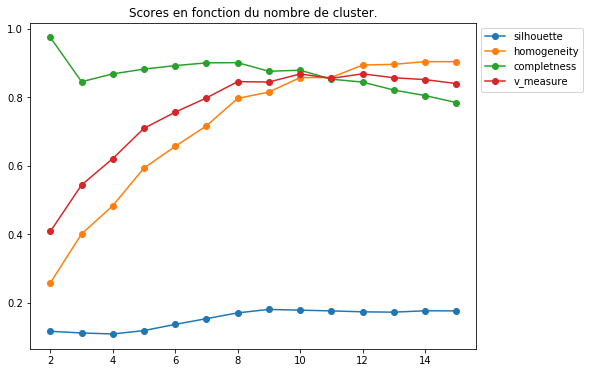

silhouette_scores : [0.11674033985112256, 0.11188954666963648, 0.10895989445239453, 0.11888125787404626, 0.13701122727669246, 0.15368571066948947, 0.17056308645095428, 0.18061975703867697, 0.17849659940596496, 0.17637337987696772, 0.17362319379744087, 0.1726407155529682, 0.17670992249010575, 0.17633457435967023]


In [33]:
summary_list = []
nb_clusters = range(2,16)
for nb_cluster in nb_clusters: 
    ach = AgglomerativeClustering(n_clusters=nb_cluster)
    summary = scoreCAH(ach, digits.data)
    summary_list.append(summary)   
silhouette_scores = [k['silhouette_score'] for k in summary_list]
homogeneity_scores = [k['homogeneity_score'] for k in summary_list]
completness_scores = [k['completness_score'] for k in summary_list]
v_measure_scores = [k['v_measure_score'] for k in summary_list]
plt.plot(nb_clusters, silhouette_scores, marker="o", label="silhouette")
plt.plot(nb_clusters, homogeneity_scores, marker="o", label="homogeneity")
plt.plot(nb_clusters, completness_scores, marker="o", label="completness")
plt.plot(nb_clusters, v_measure_scores, marker="o", label="v_measure")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Scores en fonction du nombre de cluster.")
plt.show()

print("silhouette_scores : " + str(silhouette_scores))

Nous avons analysé ci-dessus la variation du silhouette score selon le stade d'arrêt du CAH, c'est-à-dire en faisant varier le nombre de récursions de CAH et en le faisant s'arrêter lors de l'obtention de X clusters.
Nous avons scoré les différents cas selon les méthodes présentées précédemment afin d'analyser plus en détail les résultats : 
- Tout d'abord, on peut voir que les  __silhouette_scores__ obtenus sont assez bas, entre 0.1 et 0.2. Ce résultat est assez moyen et montre que les classes ne sont pas clairement distinctes.
- Pour ce qui est du __homogeneity_score__, il augmente avec le nombre de clusters. Cela peut sembler cohérent dans le sens où plus il y aura de clusters, plus les individus pourront être différenciés et il y a donc une chance plus importante que chaque cluster rassemble des individus appartenant à une même classe. 
- D'un autre coté, avoir un __completnes_score__ élevé pour nb_cluster = 2 ne signifie pas que le meilleur nombre de cluster est 2. En effet, ce score s'explique pas le fait qu'avec peu de clusters, il y a plus de chance que des individus d'une même classe soient associés à un même cluster car il y a peu de clusters. 
- L'analyse des __homogeneity_scores__, __completness_score__ et __v_measure__ permettent de se rendre compte que les scores sont les meilleurs pour 10 clusters  environ. Ils traduisent la qualité du clustering pour 10 clusters en terme de rassemblement des individus au sein d'un même cluster.

- Le __silhouette_scores__ donne un score optimal pour 9 clusters. Ce score permet de quantifier la séparation entre les clusters ainsi que la densité de population au sein d'un cluster. Un score de 0.18 pour 9 cluster signifie que les différents clusters ne sont pas très éloignés les uns des autres, voire s'entrecoupent entre eux. Cependant, avoir un score positif est encourageant. Globalement, le nombre de clusters n'influe pas trop sur la séparation et la densité des clusters.


Ces résultats semblent cohérents. En effet, le nombre de clusters à trouver est de 10 et l'analyse des scores permet de nous approcher de ce nombre.

#### Dendrogramme de la CAH

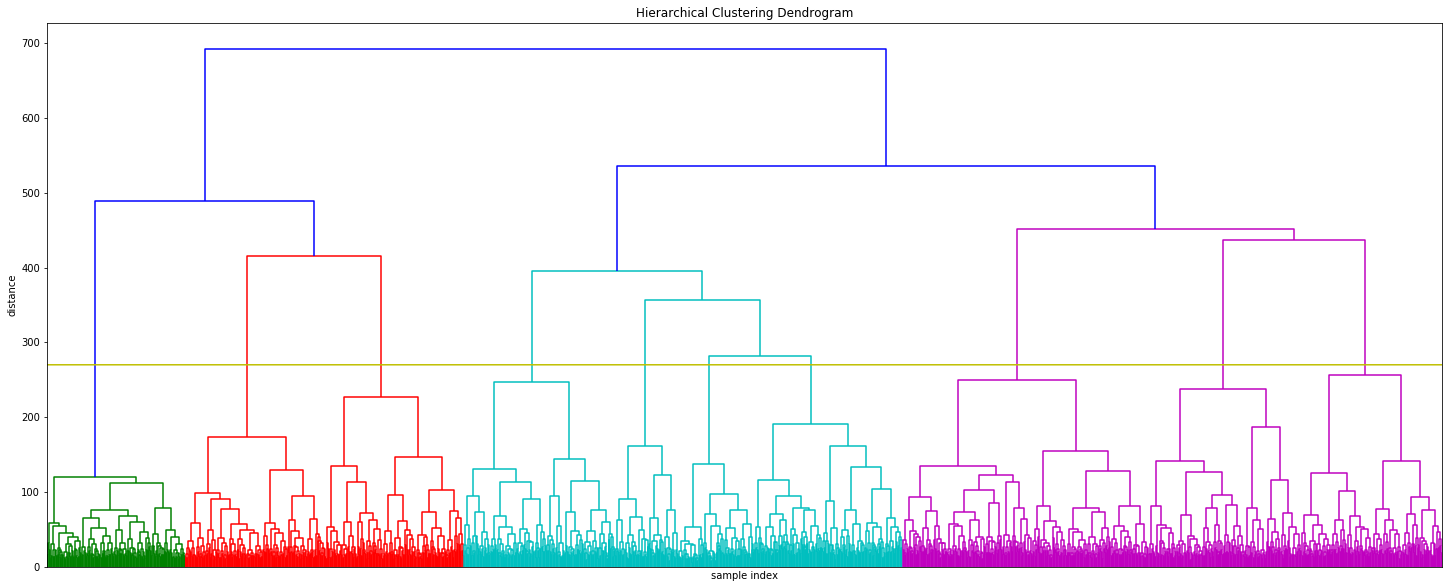

In [17]:
import scipy 
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

X = scipy.spatial.distance.pdist(digits.data,'euclidean')

Z = linkage(X, 'ward')


plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    no_labels=True,
)
horiz_line_data = np.array([270 for i in range(50000)])
plt.plot(horiz_line_data, 'y') 
plt.show()

#### Analyse du dendrogramme 

Le dendrogramme ci-dessus a été réalisé grâce au package de clustering de __scipy__. En effet, sklearn ne permet pas de réaliser de telle figure. 
Ce dendrogramme représente les fusions de clusters qui ont été réalisées par ACH, jusqu'à arriver à un seul cluster (en haut).

Nous avons vu en cours que la distance entre chaque branche était proportionnelle à la distance entre les clusters. 
La ligne jaune horizontale que nous avons dessinée manuellement marque le niveau où la distance entre les branches est la plus élevée. Nous pouvons alors compter 10 branches. Chaque branche représente un cluster. On a donc 10 clusters au niveau de la ligne jaune, qui est le niveau de récursion pour lequel les distances interclusters sont maximales.

L'analyse visuelle du dendrogramme nous permet de confirmer que le nombre optimal de clusters est de 10 pour classifier les digits.

#### Variation de la méthode de linkage

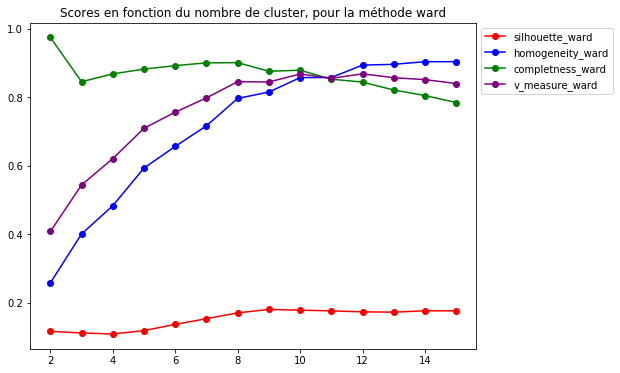

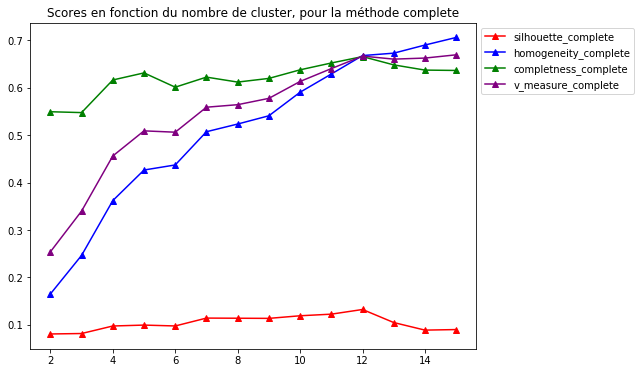

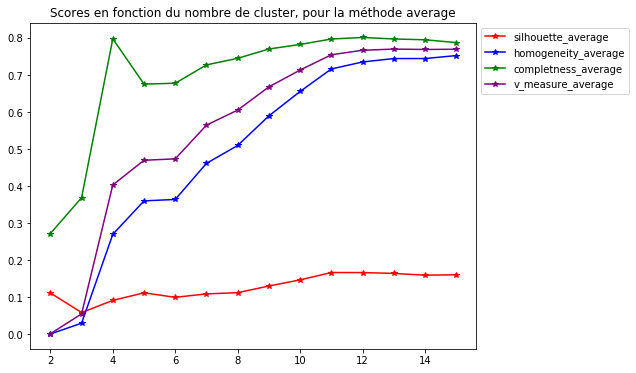

In [35]:
summary_list = []
linkage_method = ['ward', 'complete', 'average']
markers = ["o","^", "*"]
nb_clusters = range(2,16)
for l,marker in zip(linkage_method, markers) :
    for nb_cluster in nb_clusters: 
        ach = AgglomerativeClustering(n_clusters=nb_cluster, linkage=l)
        summary = scoreCAH(ach, digits.data)
        summary_list.append(summary)   
    
    silhouette_scores = [k['silhouette_score'] for k in summary_list if k['model'].linkage == l]
    homogeneity_scores = [k['homogeneity_score'] for k in summary_list if k['model'].linkage == l]
    completness_scores = [k['completness_score'] for k in summary_list if k['model'].linkage == l]
    v_measure_scores = [k['v_measure_score'] for k in summary_list if k['model'].linkage == l]
    plt.plot(nb_clusters, silhouette_scores, marker=marker, label="silhouette_"+l, color='red')
    plt.plot(nb_clusters, homogeneity_scores, marker=marker, label="homogeneity_"+l, color='blue')
    plt.plot(nb_clusters, completness_scores, marker=marker, label="completness_"+l, color='green')
    plt.plot(nb_clusters, v_measure_scores, marker=marker, label="v_measure_"+l, color='purple')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title("Scores en fonction du nombre de cluster, pour la méthode " + l)
    plt.show()

#### Pour y voir plus clair...

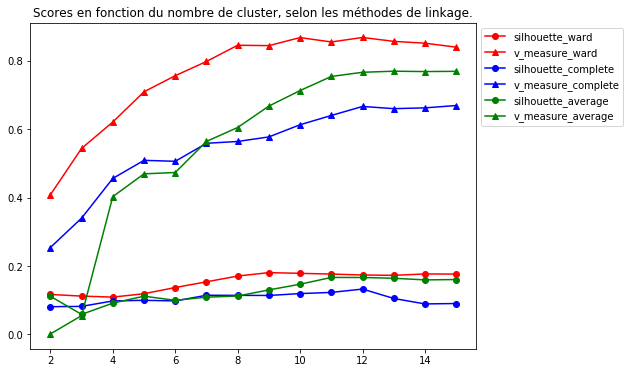

In [40]:
summary_list = []
linkage_method = ['ward', 'complete', 'average']
colors = ["red", "blue", "green"]
nb_clusters = range(2,16)
for l,col in zip(linkage_method, colors) :
    for nb_cluster in nb_clusters: 
        ach = AgglomerativeClustering(n_clusters=nb_cluster, linkage=l)
        summary = scoreCAH(ach, digits.data)
        summary_list.append(summary)   
    
    silhouette_scores = [k['silhouette_score'] for k in summary_list if k['model'].linkage == l]
    v_measure_scores = [k['v_measure_score'] for k in summary_list if k['model'].linkage == l]
    plt.plot(nb_clusters, silhouette_scores, marker="o", label="silhouette_"+l, color=col)
    plt.plot(nb_clusters, v_measure_scores, marker="^", label="v_measure_"+l, color=col)
    
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Scores en fonction du nombre de cluster, selon les méthodes de linkage.")
plt.show()

#### Analyse de la méthode de linkage.

La méthode de linkage est le critère d'évaluation des clusters afin de procéder à la fusion de deux clusters. La fusion va être réalisée entre les deux clusters qui permettent de minimiser ce critère d'évaluation. Ces méthodes de linkage permettent d'évaluer la dissimilarité inter classe.

Il existe 3 méthodes de linkage : ward, complete et average. 

- __ward__ : l'objectif de cette méthode est de minimiser la somme des différences au carrés entre les clusters. Elle se rapporte à une minimisation de variance.
- __complete__ : aussi appelé maximum linkage, la dissimilarité inter classe est donnée par la distance maximale entre deux points des deux clusters considérés (resp., il existe aussi minimum linkage). On va alors fusionner les clusters dont la dissimilarité est la plus faible.
- __average__ :  la dissimilarité est ici donnée par la moyenne des distances entre tous les points des deux clusters considérés. 

Nous avons d'abord affiché les différents scores des méthodes de linkage sur des graphiques séparés, dans un soucis de lisibilité. Nous pouvons remarquer que les courbes de score ont globalement la même allure : le __silhouette_score__ reste assez bas alors que les 3 autres scores croissent globalement avec le nombre de clusters pour chaque méthode de linkage.

Dans le dernier graphique, nous avons choisi de n'afficher que le __v_measure_score__ et __silhouette_score__. En effet, le __v_measure_score__ comprend les __homogeneity_scores__ et __completness_scores__.

Nous pouvons alors maintenant examiner quelle est la meilleure méthode de linkage : 
 - en ce qui concerne le __v_measure_score__, celui-ci augmente avec le nombre de clusters pour toutes les méthodes de linkage. Il est le meilleur pour la méthode de __ward__ (de l'ordre de 0.82 pour 10 clusters). La méthode __complete__ semble plafonner à un score de 0.6 contre environ 0.7 pour __complete__. On peut donc en déduire que la méthode ward donne des clusters qui sont plus homogènes et où le nombre d'erreur de clustering est plus bas.
 - pour ce qui est du __silhouette_score__, il reste entre 0.1 et 0.2 pour les différentes méthodes. Un ordre semble quand même s'établir entre les méthodes de linakge : ward, average, complete (du meilleur au pire). La méthode __ward__ permet donc d'obtenir les meilleurs résultats, ici en termes de maximisation de la distance interclasse et de la minimisation de la distance intraclasse.
 

La méthode ward semble donc être la plus appropriée pour traiter le problème du clustering des digits.


#### Exectuer le code qui suit

Computing embedding
Done.
ward : 0.69s
average : 0.63s
complete : 0.55s


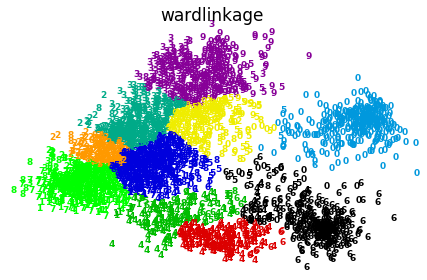

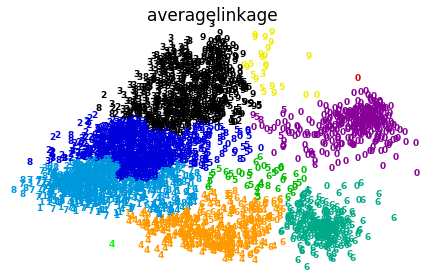

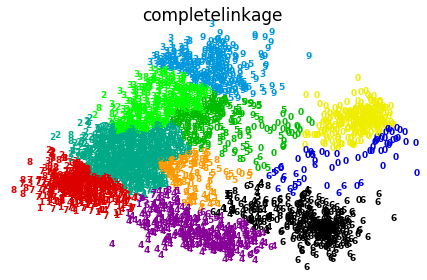

In [18]:
from time import time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets

digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

np.random.seed(0)

def nudge_images(X, y):
# Having a larger dataset shows more clearly the behavior of the
# methods, but we multiply the size of the dataset only by 2, as the
# cost of the hierarchical clustering methods are strongly
# super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),.3 * np.random.normal(size=2),mode='constant',).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y
X, y = nudge_images(X, y)
#-------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
#-------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")
from sklearn.cluster import AgglomerativeClustering
for linkage in ('ward', 'average', 'complete'):
    clustering=AgglomerativeClustering(linkage=linkage,n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))
    plot_clustering(X_red,X,clustering.labels_,"%slinkage"%linkage)
plt.show()

Le code précédent réalise trois clusterings avec les trois méthodes de linkage vues précédemment et avec un nombre de clusters attendu de 10. 
Le résultat est ensuite affiché sous la forme de nuages de points. 

- Wardlinkage : Le clustering via cette méthode semble correct. En effet, le centre des nuages de points semble n'être composé que d'individus appartenant à la même classe. Comme vu précédemment dans cette analyse, comme le __silhouette_score__ n'est pas élevé, les distances interclusters sont faibles et on a donc quelques individus qui se retrouvent dans le cluster voisin de leur classe réelle.

- Averagelinkage : On remarque qu'un cluster n'a jamais été fusionné lors du clustering : un zéro rouge est seul, sur la droite du nuage de points. De plus, les clusters verts et jaune ont très peu d'individus et ceux-ci ne sont pas très consistants (0,5,6 pour le vert ; 0,5,9 pour le jaune). Ces trois clusters sont donc assez mauvais et il ne reste donc que 7 clusters pour catégoriser la quasi-totalité des individus.

- CompleteLinkage : Le complete linkage semble être correct. Cependant, les individus appartenant aux classes 0,5 et 6 sont assez mélangés. Là aussi, avec un __silhouette_score__ faible, les distances interclusters sont réduites et certains individus sont associés à un cluster voisin de leur classe réelle.


#### Bilan sur CAH : 

CAH est donc un algorithme d'apprentissage non supervisé. Il commence donc par mettre chaque individu dans un cluster différent. Les clusters les plus proches vont ensuite être fusionnés. La proximité entre deux clusters est calculée selon 3 méthodes différentes : __ward__, __complete__, __average__. 

L'algorithme s'arrête lorsque le nombre de clusters demandé est atteint.

Les paramètres jouant sur la clusterisation sont le nombre de clusters et la méthode de linkage.

Les différentes méthodes de scoring permettent de caractériser la qualité du clustering selon plusieurs angles : distance inter/intra classe, homogénéité, completeness,... 

### DBSCAN 

L'algorithme d'apprentissage non supervisé DBSCAN est basé sur la formation de clusters selon la densité de points présents dans un espace : partant d'un point A, on va regarder combien de points se trouvent à une distance $epsilon$ de ce point. S'il y a plus de $min_samples$ points, on va alors former un cluster contenant ces points. On va ensuite répéter l'opération avec chaque nouveau point du cluster.

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import load_digits
import time
import numpy as np
from sklearn import metrics
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
digits=load_digits()

In [68]:
summary_list = []

def check_nb_labels(labels): 
    first_label = labels[0]
    for i in labels:
        if i != first_label:
            return True
    return False

def build_summary(model, data, target):
    summary = {}
    start_time = time.time()
    model.fit_predict(data)
    build_model_time = time.time()-start_time 
    if check_nb_labels(model.labels_): 
        sil_score = silhouette_score(data,model.labels_)
    else: 
        sil_score = -1 
        
    scores = metrics.homogeneity_completeness_v_measure(target, model.labels_)
    summary['silhouette_score'] = sil_score
    summary['homogeneity_score'] = scores[0]
    summary['completness_score'] = scores[1]
    summary['v_measure_score'] = scores[2]
    
    summary['model'] = model
    summary ['prediction'] = model.labels_
    summary['time'] = build_model_time
    return summary

#### Variation d'epsilon

Le paramètre __$epsilon$__ représente la distance maximale pour que deux échantillons soient considérés dans un même cluster. C'est donc un paramètre très important et nous allons voir que celui-ci à une véritable influence sur les résultats obtenus

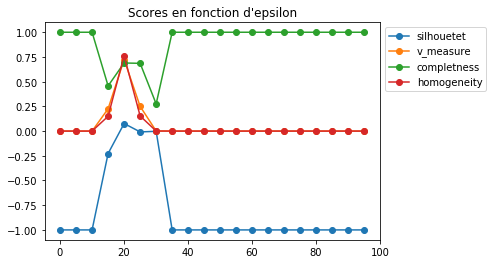

In [72]:
epsilons = np.arange(0.1, 100.0, 5.0)

summary_list = []
for epsilon in epsilons : 
    dbscan = DBSCAN(epsilon)
    summary = build_summary(dbscan, digits.data, digits.target)
    summary_list.append(summary)   
    
sil_scores = [k['silhouette_score'] for k in summary_list]
v_measure_scores = [k['v_measure_score'] for k in summary_list]
completness_scores = [k['completness_score'] for k in summary_list]
homogeneity_scores = [k['homogeneity_score'] for k in summary_list]
plt.plot(epsilons, sil_scores,  marker="o", label="silhouette")
plt.plot(epsilons, v_measure_scores,  marker="o", label="v_measure")
plt.plot(epsilons, completness_scores,  marker="o", label="completness")
plt.plot(epsilons, homogeneity_scores,  marker="o", label="homogeneity")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Scores en fonction d'epsilon")
plt.show()

Avec l'analyse précédente, on peut voir que pour le dataset des digits, l'intervalle intéressant pour la valeur d'epsilon se trouve dans l'intervalle [9,35]. Nous allons maintenant zoomer cet intervalle : 

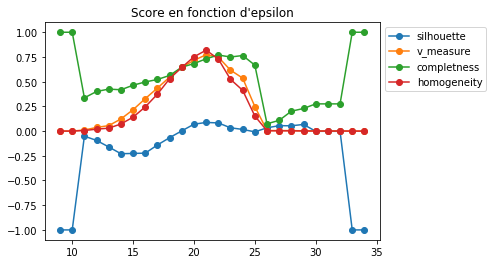

In [76]:
epsilons = np.arange(9.0, 35.0, 1.0)

summary_list = []
for epsilon in epsilons : 
    dbscan = DBSCAN(epsilon)
    summary = build_summary(dbscan, digits.data, digits.target)
    summary_list.append(summary)   
    
sil_scores = [k['silhouette_score'] for k in summary_list]
v_measure_scores = [k['v_measure_score'] for k in summary_list]
completness_scores = [k['completness_score'] for k in summary_list]
homogeneity_scores = [k['homogeneity_score'] for k in summary_list]
plt.plot(epsilons, sil_scores,  marker="o", label="silhouette")
plt.plot(epsilons, v_measure_scores,  marker="o", label="v_measure")
plt.plot(epsilons, completness_scores,  marker="o", label="completness")
plt.plot(epsilons, homogeneity_scores,  marker="o", label="homogeneity")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Score en fonction d'epsilon")
plt.show()

#### Evaluation du meilleur epsilon

In [86]:
scores = [sil_scores[i] + homogeneity_scores[i] + completness_scores[i] for i in range(len(sil_scores))]
print("Espilon optimal selon la somme des silhouette, homogeneity et completness score : ", 9 + scores.index(max(scores)))
print("Espilon optimal selon l'homogeneity score : ", 9 + homogeneity_scores.index(max(homogeneity_scores)))
print("Espilon optimal selon le completness score : ", 9 + completness_scores.index(max(completness_scores)))
print("Espilon optimal selon le silhouette score : ", 9 + sil_scores.index(max(sil_scores)))
print("Espilon optimal selon le v_measure score : ", 9 + v_measure_scores.index(max(v_measure_scores)))

Espilon optimal selon la somme des silhouette, homogeneity et completness score :  21
Espilon optimal selon l'homogeneity score :  21
Espilon optimal selon le completness score :  9
Espilon optimal selon le silhouette score :  21
Espilon optimal selon le v_measure score :  21


On peut donc voir que la valeur d'$epsilon$ optimale est de 21 pour l'ensemble de données des digits, et ce quelque soit la méthode de scoring choisie pour l'évaluer.
Il nous semble cependant que l'évaluation du meilleur $epsilon$ en se basant sur le scoring v_measure est le plus approprié. Le score de v_measure, qui mesure l'homogénéité d'un cluster et la répartition d'une classe semble être le plus approprié dans le sens où l'homogénéité d'un cluster va, en partie bien sur, dépendre de la taille du cluster construit autour de chaque point. 

#### Variation de min_samples :

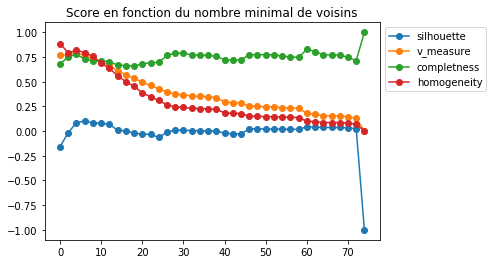

In [142]:
minNeighbors = range(0, 75, 2)

summary_list = []
for n in minNeighbors : 
    dbscan = DBSCAN(eps=21, min_samples=n)
    summary = build_summary(dbscan, digits.data, digits.target)
    summary['nb_clusters'] = dbscan.labels_
    summary_list.append(summary)   
    
    
sil_scores = [k['silhouette_score'] for k in summary_list]
v_measure_scores = [k['v_measure_score'] for k in summary_list]
completness_scores = [k['completness_score'] for k in summary_list]
homogeneity_scores = [k['homogeneity_score'] for k in summary_list]
plt.plot(minNeighbors, sil_scores,  marker="o", label="silhouette")
plt.plot(minNeighbors, v_measure_scores,  marker="o", label="v_measure")
plt.plot(minNeighbors, completness_scores,  marker="o", label="completness")
plt.plot(minNeighbors, homogeneity_scores,  marker="o", label="homogeneity")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Score en fonction du nombre minimal de voisins")
plt.show()

In [150]:
scores = [sil_scores[i] + homogeneity_scores[i] + completness_scores[i] for i in range(len(sil_scores))]
print("min_samples optimal selon la somme des silhouette, homogeneity et completness score : ", scores.index(max(scores))*2)
print("min_samples optimal selon l'homogeneity score : ", homogeneity_scores.index(max(homogeneity_scores))*2)
print("min_samples optimal selon le completness score : ", completness_scores.index(max(completness_scores))*2)
print("min_samples optimal selon le silhouette score : ", sil_scores.index(max(sil_scores))*2)
print("min_samples optimal selon le v_measure score : ", v_measure_scores.index(max(v_measure_scores))*2)

min_samples optimal selon la somme des silhouette, homogeneity et completness score :  4
min_samples optimal selon l'homogeneity score :  0
min_samples optimal selon le completness score :  74
min_samples optimal selon le silhouette score :  6
min_samples optimal selon le v_measure score :  4


Cette fois-ci, il semble que le choix du meilleur min_samples n'est pas aussi facile que pour epsilon. 
Le paramètre min_samples permet de considérer qu'un cluster peut-être établi si pour un individu, on trouve plus de min_samples individus à une distance inférieure à epsilon. Ce sont donc ces deux paramètres qui jouent sur le choix de densité désiré pour la formation de clusters.

Les résultats obtenus ne nous semblent pas convaincants. 
Nous allons les vérifier dans ce qui suit : 

In [147]:
min_samples_nb_clusters = {}
for i in summary_list:
    clusters_list = []
    for j in i['nb_clusters']:
        if j not in clusters_list:
            clusters_list.append(j)
    min_samples_nb_clusters[i['model'].get_params()['min_samples']] = len(clusters_list)

In [148]:
print(min_samples_nb_clusters)

{0: 233, 2: 38, 4: 18, 6: 20, 8: 21, 10: 15, 12: 14, 14: 16, 16: 13, 18: 12, 20: 9, 22: 8, 24: 8, 26: 5, 28: 4, 30: 4, 32: 4, 34: 4, 36: 4, 38: 4, 40: 4, 42: 4, 44: 4, 46: 3, 48: 3, 50: 3, 52: 3, 54: 3, 56: 3, 58: 3, 60: 2, 62: 2, 64: 2, 66: 2, 68: 2, 70: 2, 72: 2, 74: 1}


Ici, nous avons affiché les couples (min_samples:nombre de clusters obtenus).
Il nous semble que les résultats trouvés précédemment sont aberrants. 
En effet, si on prend min_samples = 4 ou 6, on peut voir que le nombre de clusters obtenus est de 18 ou 20. Or, d'après les analyses réalisée précédemment avec les autres algorithmes non supervisés, on sait que le nombre de clusters attendu est de 10. 

De même, les nombres de clusters obtenus pour min_samples = 0 et min_samples = 74 sont aberrants. 

### Bilan DBSCAN :

Comme nous avons pu le voir, DBSCAN ne semble pas approprié pour le problème de clustering des digits. 
En revanche, cet algorithme apporte une nouvelle approche par rapport aux algorithmes précédents. En effet, il se base sur une notion de densité et réalise une analyse de proche en proche. Les autres algorithmes partaient du principe que les clusters étaient forcément convexes, ce que DBSCAN ne fait. 
Si DBSCAN n'est pas approprié pour clusteriser les digits (car les clusters de digits sont convexes comme on peut le voir sur les nuages de points ci-dessus), il pourrait être utilisé dans d'autres cas.

## Conclusion

Cette étude comparative nous a permis de nous rendre compte de l’importance du choix de classifieur vis à vis des données d’entrées à classifier. En effet, nous avons pu voir que les différents algorithmes utilisés donnent des résultats très différents pour un même jeu de données.  <br>
Les différents algorithmes testés précédemment, présentent tous une approche différente, en effet :<br>
- Dans l’algorithme __K-Means__, le nombre de cluster à réaliser est un paramètre d’entrée, or, bien souvent, lorsque l’on souhaite classifier en apprentissage non supervisé, nous n’avons aucune idée de comment sont réparties les données, et donc aucune idée du K optimal pour classer les données. Ceci nécessite donc de faire varier k et de scorer l’algorithme à plusieurs reprises. 
- L’avantage d’utiliser la __classification ascendante hiérarchique__ est que celle-ci est déterministe contrairement à la méthode __K-means__, en effet, la méthode k-means est comme nous l’avons vu, très sensible par rapport à sa phase d'initialisation
- __DBSCAN__, à la différence de __K-means__, n’attend pas en paramètre le nombre de cluster, mais se base plutôt sur une analyse de densité des clusters. 
- De la même manière, les différents algorithmes, ne s’intéressent pas à des données réparties de la même manière, en effet, là où __k-means__ trouvera uniquement des clusters convexes, la méthode __DBSCAN__ pourra obtenir des clusters dont la forme est potentiellement concave.

